In [1]:
import numpy as np
import random as rnd
import time

import matplotlib.pyplot as plt
import pantarei as rei

import src.system as sys
import src.interaction as interaction
import src.MonteCarlo as mc

from src.simulation_module import plot_val_over_NMC, visualize_3dmol # simulation, 

# simulation = rei.Task(simulation,clear_first=True)

# job = rei.Job(simulation)

scheduler = rei.scheduler.ThreadScheduler(backend='process')
# job = rei.Thread(simulation, scheduler=scheduler)

In [2]:
# setup default parameters
param_interact=None
param_sys=None
mc_par_over_box=0.1
N = 0
configuration='fcc'#'cubic'#

parameters_interaction = dict()
if param_interact is None:
    parameters_interaction['sigma'] = 1.0       # Unità di misura di lunghezza
    parameters_interaction['epsilon'] = 1.0     # Unità di misura di energia

    parameters_interaction['rcut'] = 2.5*1.0    # Distanza di taglio per il potenziale cut and shift
else:
    parameters_interaction = param_interact

parameters_system = dict()
parameters_system['tot_N'] = 1000
if param_sys is None:
    M = 5                                               # Cells per side
    a = 1.0                                             # Lattice spacing
    box = 3
    n = box**3*4                                        # 4, 32, 108, 256, 500, 864, 1372
    if configuration == 'cubic':
        parameters_system['M'] = M
        parameters_system['a'] = a
        N = M**3
    elif configuration == 'fcc':
        parameters_system['n'] = n
        parameters_system['box'] = box
        N  = n
else:
    parameters_system = param_sys

In [ ]:
# def time_tries(steps):
#     temperature = 1.
#     volume = 7**3
#     z = 0.05
#     density = N / volume

#     interact = interaction.Interaction(parameters_interaction, potential='lj_c')#,flags='-fbounds-check')

#     my_sys = sys.System(temperature, z, interact, parameters_system, config=configuration)
#     my_sys.density = density
#     montecarlo = mc.MonteCarlo(my_sys, interact)
#     # rnd.seed(seed)

#     t0 = time.time()
#     for _ in range(int(steps)):
#         montecarlo.run()
#     print(time.time() - t0)
#     print(my_sys.current_N,montecarlo.accept_ratio)
#     return {
#             # 'sec 0': montecarlo.t_counter_d_0, 
#             # 'sec 1': montecarlo.t_counter_d_1, 
#             # 'sec 2': montecarlo.t_counter_d_2, 
#             'displacement': montecarlo.t_counter_i, 
#             'insertion': montecarlo.t_counter_i, 
#             'removal': montecarlo.t_counter_r,
#             # 'energy': montecarlo.t_counter_E,
#             # 'pbc': montecarlo.t_counter_pbc,
#             # 'exp': montecarlo.t_counter_exp
#     }

# task = rei.Task(time_tries,clear_first=True)
# task = rei.Task(time_tries)#,clear_first=True)
# # data = task(steps=4e3+10) # 0-no E, 1-dis, 2-ins, 3-rem, 4-tot, 5-pbc, 6-exp, 7-only disp
# data = task(steps=5e3+14) # 8-sections disp, 10-njit disp, 11-njit exp, 12-njit ins, 13
# sum = 0
# for key in data.keys(): sum += data[key]
# for key in data.keys(): print(f'{key:15} -> {data[key]/sum*100:.0f}%')
# print(sum)

# # data = task(steps=5e3+10) # 8-sections disp, 10-njit
# # print(data)
# # sum = 0
# # for key in data.keys():
# #     sum += data[key]
# # sum

# # data = task(steps=5e3+11) # 8-sections disp, 10-njit
# # print(data)
# # sum = 0
# # for key in data.keys():
# #     sum += data[key]
# # sum

29.310444593429565
263 0.007003501750875438
displacement    -> 35%
insertion       -> 35%
removal         -> 31%
25.91396951675415


In [96]:
def simulation_GC(temperature,volume,z,steps,seed):
    density = N / volume

    interact = interaction.Interaction(parameters_interaction, potential='lj_c')#,flags='-fbounds-check')

    my_sys = sys.System(temperature, z, interact, parameters_system, config=configuration)
    my_sys.density = density
    montecarlo = mc.MonteCarlo(my_sys, interact)
    rnd.seed(seed)

    tot_time = 0
    t0 = time.time()
    P,E,d = [], [], []
    for i in range(int(steps)):
        montecarlo.run()
        if i%(int(steps/20)) == 0: 
            print(f'Progress {seed}: {int(i/steps*100)}%, N={my_sys.current_N}, d={my_sys.density}')
        if i%100 == 0:
            E.append(my_sys.energy)
            P.append(my_sys.pressure)
            d.append(my_sys.density)

            t1 = time.time()
            tot_time += (t1-t0)/my_sys.current_N
            t0 = t1
    
    acceptance = dict()
    acceptance['accept_ratio'] = montecarlo.accept_ratio
    acceptance['accepted_moves_d'] = montecarlo.accepted_moves_d
    acceptance['accepted_moves_i'] = montecarlo.accepted_moves_i
    acceptance['accepted_moves_r'] = montecarlo.accepted_moves_r
    acceptance['tot_mc_moves'] = montecarlo.tot_mc_moves

    return {'pressure':P, 'energy': E, 'density': d,
            'tot_time': tot_time/steps,
            'acceptance': acceptance}
            # 'system': my_sys, 'montecarlo': montecarlo}

task = rei.Task(simulation_GC,clear_first=True)
task = rei.Task(simulation_GC)
job = rei.Thread(task, scheduler=scheduler)
# job = simulation_GC

###################################################################################
steps = 2e5
steps = 2.5e4
volume = 8.735**3
# temperature = 1.21
# temperature = 1.19
temperature = 1.18
temperature = 1.175
temperature = 1.173
# temperatures = [1.21, 1.19, 1.17, 1.15]
# z = 0.067
# z = 0.065
# z = 0.064
# z = 0.061
# z = 0.060
z = 0.0625
# z = 0.062

z_s = [0.060+0.0001*k for k in range(11)]

# data = simulation()
# data = task(temperature=temperature,volume=volume,z=z,steps=steps,seed=s)
for z in z_s:
    for s in [1,2,3,4]:
        data = job(temperature=temperature,volume=volume,z=z,steps=steps,seed=s)

In [4]:
import src.algorithm as algo

new_algo = algo.Algorithm
# new_algo.run_simulation(steps=10)
new_algo.initialize_parameters()

TypeError: Algorithm.initialize_parameters() missing 1 required positional argument: 'self'

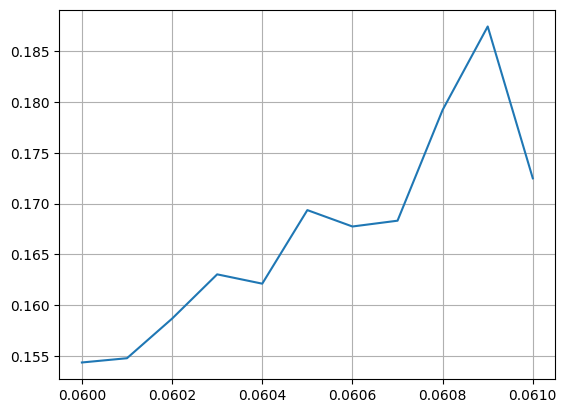

In [111]:
# temperature = 1.175
temperature = 1.173
# z_s = [0.062+0.0001*k for k in range(11)]
z_s = [0.060+0.0001*k for k in range(11)]

densities = []
for z in z_s:
    d=[]
    for s in [1,2,3,4]:
        data = job(temperature=temperature,volume=volume,z=z,steps=steps,seed=s)
        d += data['density']
    densities.append(np.mean(d))
    
plt.plot(z_s,densities)
plt.grid()

In [107]:
# rei.report()

Acceptance ratio: 0.18
Acceptance ratio: 0.16
Acceptance ratio: 0.3
Acceptance ratio: 0.16


0.30312275340406597

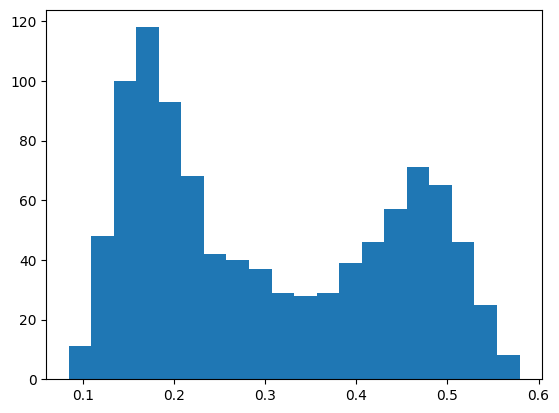

In [105]:
# data['acceptance']['accepted_moves_d']/data['acceptance']['tot_mc_moves']*3

# E = data['energy']
# P = data['pressure']
# d = data['energy']
# print(f"Acceptance ratio: {data['acceptance']['accept_ratio']:.2}")

z = 0.064
z = 0.0622
# z = 0.0625

d = []
for s in [1,2,3,4]:
    data = job(temperature=temperature,volume=volume,z=z,steps=steps,seed=s)
    d += data['density']
    print(f"Acceptance ratio: {data['acceptance']['accept_ratio']:.2}")


# plot_val_over_NMC(d,x_multipl=100,ylabel='Density')
plt.hist(d,20)
np.mean(d)

In [ ]:
# import src.system
# import time
# import src.timer as timer
# import numpy as np


import src.algorithm as algo
import pantarei as rei

my_algo = algo.Algorithm()

# Ts = [10,11,12,113]
# for T in Ts:
    # my_algo.run_simulation(temperature=T,volume=10,z=10,steps=200,clear_first=False,parallel=True,wait=True)

which_vals = {'energy': True, 'pressure': False, 'density': False, 'N': True}
print(which_vals)


steps = 2.5e2
volume = 8.735**3
T = 1.175
z = 0.0625

for s in [0,1,2,3]:
    data = my_algo.run_simulation(temperature=T,volume=volume,z=z,steps=steps,seed=s,which_vals=which_vals,
                           clear_first=True,parallel=True,wait=True)
    my_algo.plot_hist(data)


{'energy': True, 'pressure': False, 'density': False, 'N': True}


TypeError: 'int' object is not subscriptable

Progress 0: 0%, N=91, d=0.137
Progress 0: 4%, N=76, d=0.114
Progress 0: 9%, N=73, d=0.11
Progress 0: 14%, N=84, d=0.126
Progress 0: 19%, N=77, d=0.116
Progress 0: 24%, N=84, d=0.126
Progress 0: 28%, N=82, d=0.123
Progress 0: 33%, N=80, d=0.12
Progress 0: 38%, N=81, d=0.122
Progress 0: 43%, N=92, d=0.138
Progress 0: 48%, N=94, d=0.141
Progress 0: 52%, N=111, d=0.167
Progress 0: 57%, N=134, d=0.201
Progress 0: 62%, N=166, d=0.249
Progress 0: 67%, N=183, d=0.275
Progress 0: 72%, N=172, d=0.258
Progress 0: 76%, N=186, d=0.279
Progress 0: 81%, N=186, d=0.279
Progress 0: 86%, N=148, d=0.222
Progress 0: 91%, N=163, d=0.245
Progress 0: 96%, N=133, d=0.2


In [4]:
rei.report()

✅ ended   100% [1/1]
   ✅ simulation_GC/ae9700e3f8e0336f8ba73a1000137599 0:00:03 simulation_GC(kwargs={'temperature': 1.175, 'volume': 666.4824653749998, 'z': 0.0625, 'steps': 2 ...
